## Sparse Bayesian learning: Original algorithm

###### Assumptions: polynomial basis functions, scalar output, scalar input
###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys

#### Model definition (basis functions)

In [2]:
polyPower = [0,1,2,3,4,5,6] # powers of polynomial
N = len(polyPower) # number of basis
def basisFun(Xth,ith):
    return Xth**polyPower[ith]

#### True coefficients and error precision (If known)

In [3]:
trueKnown = 1 # 0 = dont plot true, 1= plot true 
CoeffTrue =[0]*N
CoeffTrue[0]=1
CoeffTrue[2]=1 
rhoTrue = 25

#### Parameters governing SBL

In [4]:
rho0 = 20 # Starting error precision
alpha0 = [1e-01]*N # Starting hyper-parameter value 
rTol = 0.01 # 0-1,below this implies irrelevance
a = rho0*0.1 # prior for rho ~ gamma(a,b)
b = 0.1 # mean=a/b, var=a/b**2
c = 1.05 # prior for hyperparameter alpha gamma(c,d), between 1-2
d = 0.000001 # +ve and close to zero
Nsbl = 105 # number of SBL iterations (add 5 always)
SBLapproach = 2 # there are two ways to update alpha
#mpl.rcParams.update({'font.size':12})
#mpl.rcParams.update({'figure.figsize':(6,4)})

#### Load observations and generate design matrix

In [5]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,N))
for i in range(0,M):
    for j in range(0,N):
        Phi[i,j] = basisFun(Xobs[i],j)

#### Routine to update posterior statistics using Bayesian linear regression

In [6]:
def updateStat(alphai,rhoi):
    Ainv = np.diag(1/alphai)
    Bi = np.matmul(Phi,np.matmul(Ainv,np.transpose(Phi))) + np.identity(M)/rhoi
    Binvi = la.inv(Bi)
    Ki = np.matmul(Ainv,np.matmul(np.transpose(Phi),Binvi))
    Pi = Ainv - np.matmul(Ki,np.matmul(Phi,Ainv))
    mi = np.matmul(Ki,Yobs)
    logEvidi = np.log(st.multivariate_normal.pdf(Yobs,[0]*M,Bi))
    return mi, Pi, logEvidi

#### SBL original algorithm

In [7]:
alpha = np.zeros((N,Nsbl)); r = np.zeros((N,Nsbl))
Wvar = np.zeros((N,Nsbl));  m = np.zeros((N,Nsbl))
KLdiv = np.zeros((N,Nsbl)); P = np.zeros((N,N))
logEvid = [0]*Nsbl; gof = [0]*Nsbl; 
rho = [0]*Nsbl; sparsity = [0]*N
alpha[:,0] = alpha0;
rho[0] = rho0;
curList = list(range(N))

In [8]:
for j in range(0,Nsbl-1):
    m[:,j],P,logEvid[j] = updateStat(alpha[:,j],rho[j])
    Wvar[:,j] = np.diag(P)
    for ii in range(0,N):
        r[ii,j]   = 1-alpha[ii,j]*Wvar[ii,j] 
        KLdiv[ii,j] = 0.5*(-np.log(alpha[ii,j]*Wvar[ii,j])- 1 + alpha[ii,j]*(Wvar[ii,j] + m[ii,j]**2))
        if r[ii,j] > rTol: sparsity[ii] = 1
        else:                      sparsity[ii] = 0
    i=j%N
    if i == 0:  np.random.shuffle(curList)
    curi = curList[i]
    if SBLapproach == 1:
        alpha[curi,j] = (1+2*(c-1))/(Wvar[curi,j] + m[curi,j]**2+2*d)
        rho[j+1] = (M+2*(a-1))/(np.power(la.norm(Yobs-np.matmul(Phi,m[:,j])),2)\
                            +np.trace(np.matmul(P,np.matmul(np.transpose(Phi),Phi)))+2*b)
    elif SBLapproach == 2:
        alpha[curi,j] = (r[curi,j]+2*(c-1))/(m[curi,j]**2+2*d)
        rho[j+1] = (M-np.sum(r[:,j])+2*(a-1))/(np.power(la.norm(Yobs-np.matmul(Phi,m[:,j])),2)+2*b) 
    alpha[:,j+1] = alpha[:,j]
    gof[j] = st.multivariate_normal.pdf(Yobs,np.matmul(Phi,m[:,j]),np.identity(M)/rho[j])

In [9]:
print(' i    mean      var       prec     alpha       r       KLdiv   Sparse?')
for i in range(0,N):
    print("{0:2d}{1:10.2e}{2:10.2e}{3:10.2e}{4:10.2e}{5:10.2e}{6:10.2e}{7:5d}".format(\
        int(i),m[i,-2],Wvar[i,-2],1/Wvar[i,-2],alpha[i,-2],r[i,-2],KLdiv[i,-2],sparsity[i]))
print("\nLogEvid : {0:9.2e}\nRho: {1:14.2e}\nSparsity: {2:3d}/{3:3d}".format(\
    logEvid[-2],rho[-2],int(sum(sparsity)),N))

 i    mean      var       prec     alpha       r       KLdiv   Sparse?
 0  1.03e+00  1.76e-03  5.70e+02  1.03e+00  9.98e-01  3.21e+00    1
 1 -1.88e-05  2.00e-05  5.01e+04  5.01e+04  1.67e-04  8.89e-06    0
 2  8.68e-01  8.54e-03  1.17e+02  1.44e+00  9.88e-01  2.25e+00    1
 3  2.35e-05  2.00e-05  5.00e+04  5.00e+04  8.53e-05  1.38e-05    0
 4  1.33e-05  2.00e-05  5.01e+04  5.01e+04  1.79e-04  4.47e-06    0
 5  4.91e-06  1.99e-05  5.01e+04  5.01e+04  2.63e-04  6.22e-07    0
 6 -2.75e-07  1.99e-05  5.02e+04  5.02e+04  3.29e-04  2.89e-08    0

LogEvid :  5.30e+00
Rho:       2.51e+01
Sparsity:   2/  7


#### Plot statistics over SBL iteration

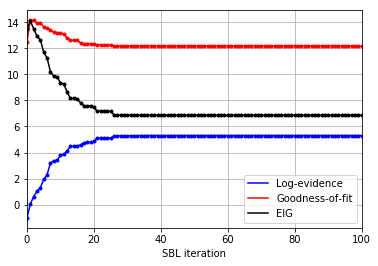

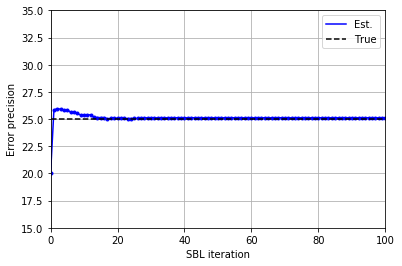

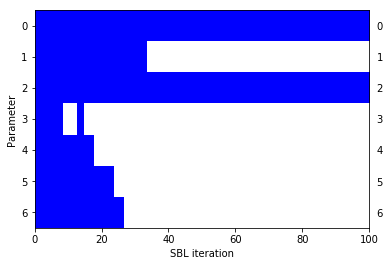

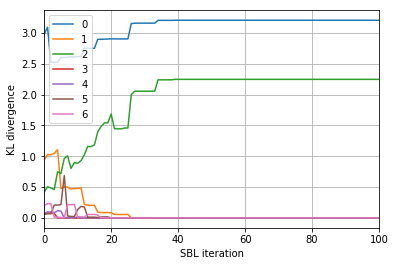

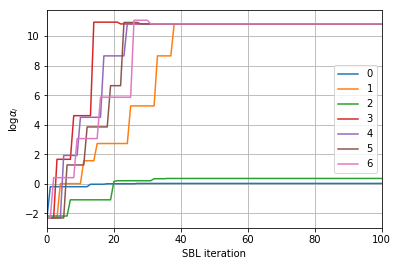

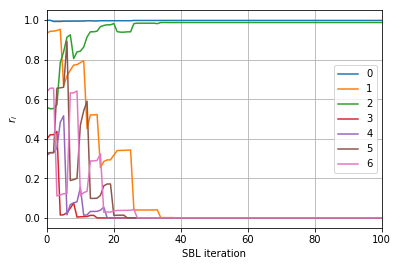

In [10]:
plt.figure(1)
plt.plot(logEvid[:-1],'b.')
plt.plot(logEvid[:-1],'b-',label='Log-evidence')
plt.plot(np.log(gof[:-1]),'r.')
plt.plot(np.log(gof[:-1]),'r-',label='Goodness-of-fit')
plt.plot(np.log(gof[:-1]) - logEvid[:-1],'k.')
plt.plot(np.log(gof[:-1]) - logEvid[:-1],'k-',label='EIG')
plt.legend(loc='best', numpoints = 1); plt.grid(True)
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.savefig('3_SBLorig_stat.eps',bbox_inches='tight')
plt.figure(2)
plt.plot(rho[:-1],'b.')
plt.plot(rho[:-1],'b-',label='Est.')
plt.plot([0,Nsbl],[rhoTrue,rhoTrue],'k--',label='True')
plt.legend(loc='best', numpoints = 1); plt.grid(True)
plt.xlim([0,Nsbl-5])
plt.ylim([rhoTrue-10,rhoTrue+10])
plt.ylabel('Error precision')
plt.xlabel('SBL iteration');
plt.savefig('3_SBLorig_rho.eps',bbox_inches='tight')
fig, ax = plt.subplots()
cmap = mpl.colors.ListedColormap(['white', 'blue'])
bounds = [0,rTol,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(r, cmap=cmap, aspect='auto',norm=norm)
ax.tick_params(labelright=True)
ax.set_yticks(np.arange(0, N, 1))
plt.xlim([0,Nsbl-5])
plt.ylabel('Parameter')
plt.xlabel('SBL iteration')
plt.savefig('3_SBLorig_sparsity.eps',bbox_inches='tight')
plt.figure(4)
for i in range(0,N):
    plt.plot(KLdiv[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel('KL divergence')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.legend(loc='best', numpoints = 1);
plt.savefig('3_SBLorig_kldiv.eps',bbox_inches='tight')
plt.figure(7)
for i in range(0,N):
    plt.plot(np.log(alpha[i,:-1]),label=str(i))
plt.grid(True)
plt.ylabel(r'$\log\alpha_i$')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.legend(loc='best', numpoints = 1);
plt.savefig('3_SBLorig_alpha.eps',bbox_inches='tight')
plt.figure(8)
for i in range(0,N):
    plt.plot(r[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel(r'$r_i$')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.legend(loc='best', numpoints = 1);
plt.savefig('3_SBLorig_r.eps',bbox_inches='tight')

#### Plot parameter marginal pdfs

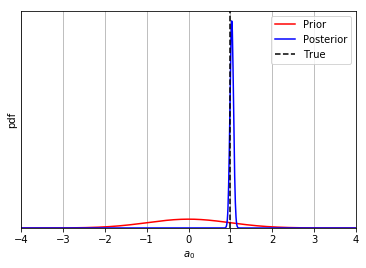

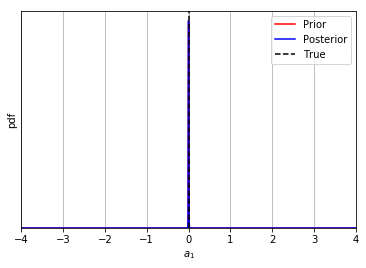

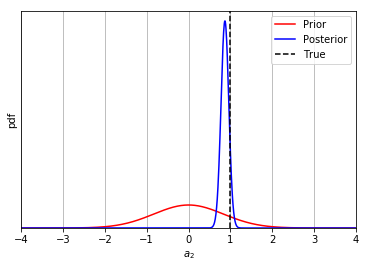

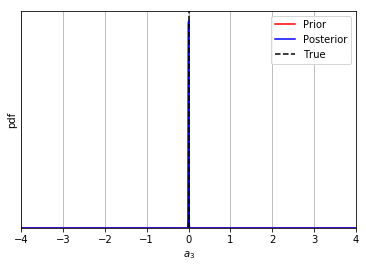

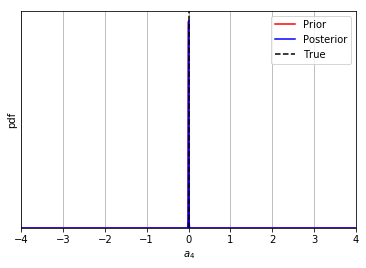

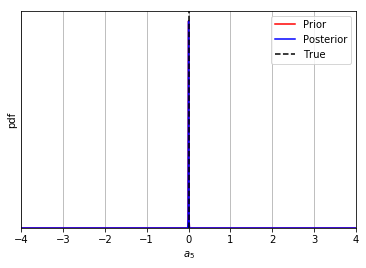

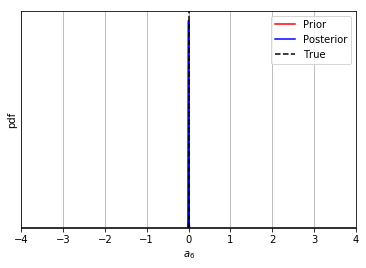

In [11]:
Wlim = [-4,4]  # xlim for plotting pdf plots
Ngrid = 1000  # density for grid generation in X
pscale=5  # for automatic bound calculation for pdf plots 
for i in range(0,N):
    Wpriormin = -pscale*np.sqrt(1/alpha[i,-2])
    Wpriormax = pscale*np.sqrt(1/alpha[i,-2])
    Wpostmin = m[i,-2]-pscale*np.sqrt(Wvar[i,-2])
    Wpostmax = m[i,-2]+pscale*np.sqrt(Wvar[i,-2])
    # comment this if using user supplied bounds Wlim
    #Wlim = [min(Wpriormin,Wpostmin),max(Wpostmax,Wpriormax)] 
    Wgrid  = np.linspace(Wlim[0],Wlim[1],Ngrid)
    Wpost  = st.multivariate_normal.pdf(Wgrid,m[i,-2],Wvar[i,-2])
    Wprior = st.multivariate_normal.pdf(Wgrid,0,1/alpha[i,-2])
    fig = plt.figure(i+1)
    plt.plot(Wgrid,Wprior,'r-',label='Prior')
    plt.plot(Wgrid,Wpost,'b-',label='Posterior')
    plt.grid(True)
    plt.yticks([])
    ax = plt.gca(); Ylim = ax.get_ylim()
    if trueKnown == 1: plt.plot([CoeffTrue[i],CoeffTrue[i]],[0,Ylim[1]],'k--',label='True')
    plt.ylim([0,Ylim[1]])
    plt.xlabel(r'$a_{'+str(i)+'}$')
    plt.ylabel('pdf')
    plt.xlim(Wlim[0],Wlim[1])
    plt.legend(loc='best', numpoints = 1)
    plt.savefig('3_SBLorig_mpdf'+str(i)+'.eps',bbox_inches='tight')

#### Plot model predictions vs true response

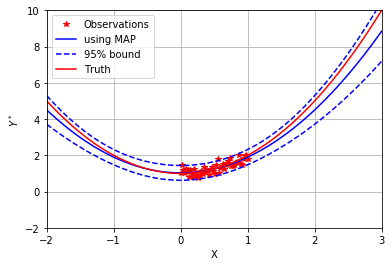

In [12]:
Xextra = 2 # width for extrapolation
Yrnge = [-2,10] 
Mnew = 100
Xrnge = [min(Xobs)-Xextra,max(Xobs)+Xextra]
Xnew = np.linspace(Xrnge[0],Xrnge[1],Mnew)
PhiNew = np.zeros((Mnew,N))
for i in range(0,Mnew):
    for j in range(0,N):
        PhiNew[i,j] = sparsity[j]*basisFun(Xnew[i],j)
Yvar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/rho[-1]
Ymean = np.matmul(PhiNew,m[:,-2])
fig = plt.figure(N+1)
plt.plot(Xobs,Yobs,'r*',label='Observations')
plt.plot(Xnew,Ymean,'b-',label='using MAP')
plt.plot(Xnew,Ymean+2*np.sqrt(np.diag(Yvar)),'b--',label='95% bound')
plt.plot(Xnew,Ymean-2*np.sqrt(np.diag(Yvar)),'b--')
if trueKnown ==1:
    Ytrue = np.matmul(PhiNew,np.transpose(CoeffTrue))
    plt.plot(Xnew,Ytrue,'r-',label='Truth')
plt.grid(True)
plt.ylabel(r'$Y^*$')
plt.xlabel('X')
plt.ylim(Yrnge)
plt.xlim([Xrnge[0],Xrnge[1]])
plt.legend(loc='best', numpoints = 1)
plt.savefig('3_SBLorig_pred.eps',bbox_inches='tight')